In [1]:
# !pip install tensorflow

In [2]:

import pyodbc
import re
import plotly.express as px
import plotly.graph_objects as go
import pandas as pd
import numpy as np
import seaborn as sns
from zipfile import ZipFile
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import cv2
from sklearn.model_selection import train_test_split
from sklearn.multiclass import OneVsOneClassifier
import tensorflow as tf
from sklearn.linear_model import Perceptron
from tensorflow import keras

In [3]:

file_name = "digit-recognizer.zip"

with ZipFile(file_name, 'r') as zip:
    zip.printdir()

    print('Extracting all the files now...')
    zip.extractall()
    print('Done!')


File Name                                             Modified             Size
sample_submission.csv                          2019-12-11 20:01:20       240909
test.csv                                       2019-12-11 20:01:20     51118296
train.csv                                      2019-12-11 20:01:24     76775041
Extracting all the files now...
Done!


In [4]:
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')

In [5]:
train_df

label  pixel0  pixel1  pixel2  pixel3  pixel4  pixel5  pixel6  pixel7  \
0          1       0       0       0       0       0       0       0       0   
1          0       0       0       0       0       0       0       0       0   
2          1       0       0       0       0       0       0       0       0   
3          4       0       0       0       0       0       0       0       0   
4          0       0       0       0       0       0       0       0       0   
...      ...     ...     ...     ...     ...     ...     ...     ...     ...   
41995      0       0       0       0       0       0       0       0       0   
41996      1       0       0       0       0       0       0       0       0   
41997      7       0       0       0       0       0       0       0       0   
41998      6       0       0       0       0       0       0       0       0   
41999      9       0       0       0       0       0       0       0       0   

       pixel8  ...  pixel774  pixel775  pixel776  pixel777  pixel778  \
0           0  ...         0         0         0         0         0   
1           0  ...         0         0         0         0         0   
2           0  ...         0         0         0         0         0   
3           0  ...         0         0         0         0         0   
4           0  ...         0         0         0         0         0   
...       ...  ...       ...       ...       ...       ...       ...   
41995       0  ...         0         0         0         0         0   
41996       0  ...         0         0         0         0         0   
41997       0  ...         0         0         0         0         0   
41998       0  ...         0         0         0         0         0   
41999       0  ...         0         0         0         0         0   

       pixel779  pixel780  pixel781  pixel782  pixel783  
0             0         0         0         0         0  
1             0         0         0         0         0  
2             0         0         0         0         0  
3             0         0         0         0         0  
4             0         0         0         0         0  
...         ...       ...       ...       ...       ...  
41995         0         0         0         0         0  
41996         0         0         0         0         0  
41997         0         0         0         0         0  
41998         0         0         0         0         0  
41999         0         0         0         0         0  

[42000 rows x 785 columns]

In [6]:
X_train = train_df.loc[:, train_df.columns != 'label'].values
train_ar = np.empty((28,28,42000))

for m in range(42000):#digit
    for i in range(28):#rows
        for j in range(28):#columns
            train_ar[i][j][m] = X_train[m,i*28+j]

now train_ar has a three dimensional array: 28x28x42000. I want to display all the digits one next to the other. There are 42000 digits, we can put then in 200 columns and 210 rows. Then we need an array of size (210x28, 200x28)

In [7]:
img_train_digits = np.empty((28,5628))
col = np.empty((28,28))
row_cnt = 0
px_cnt = 0
for m in range(42000):
    px_cnt+=1
    col = np.hstack((col, train_ar[:,:,m]))
    if(px_cnt%200==0):
        if(row_cnt==0):
            img_train_digits = col
        else:
            img_train_digits = np.vstack((img_train_digits, col))
        row_cnt+=1
        col = np.empty((28,28))
img_train_digits = img_train_digits[:,29:]

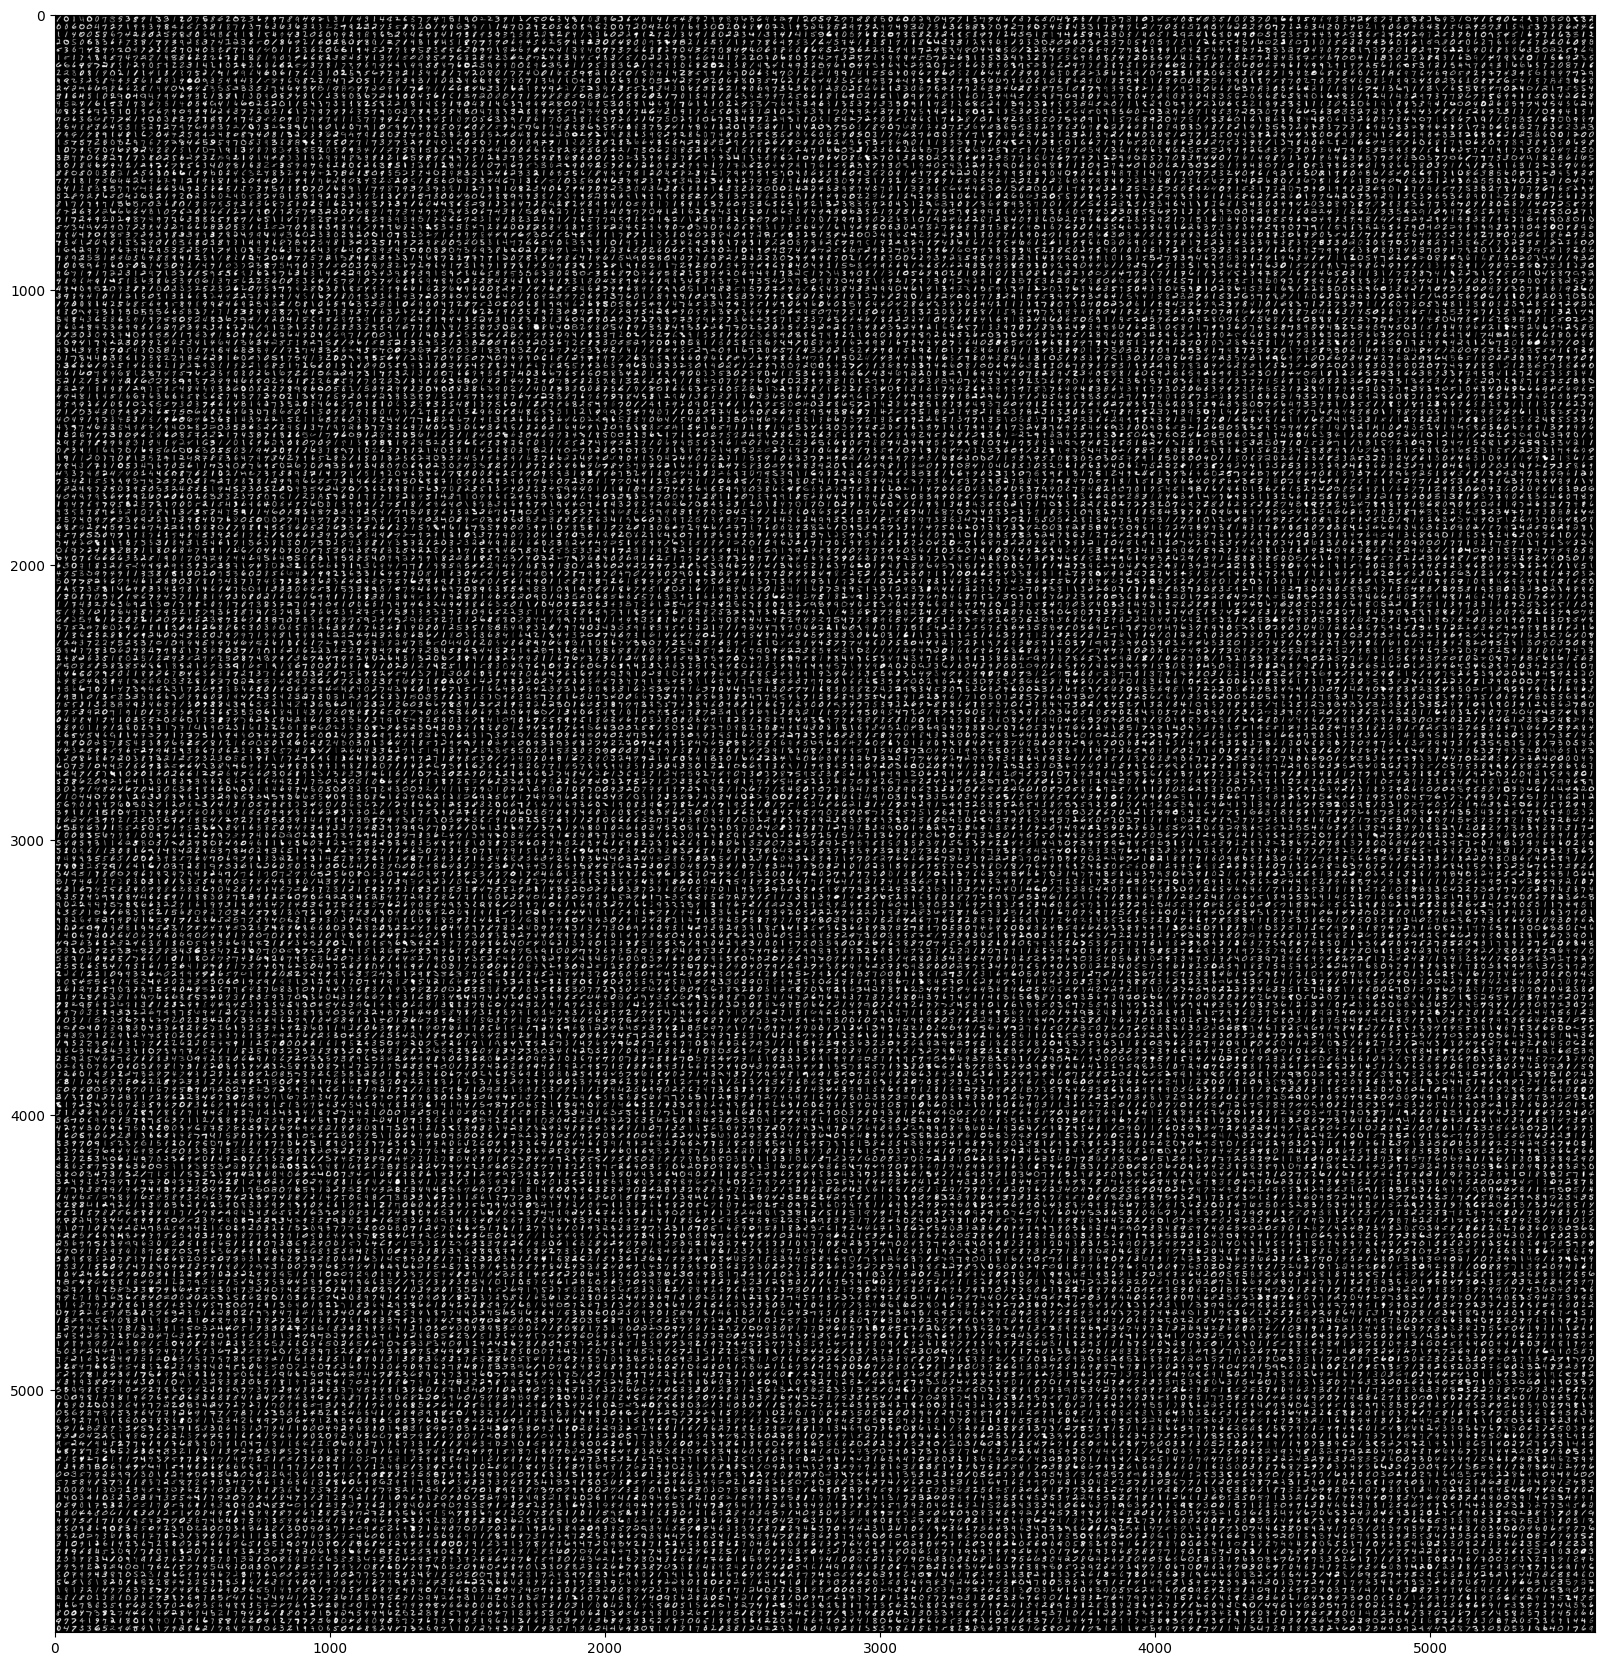

In [8]:
gr_im= Image.fromarray(img_train_digits)
plt.figure(figsize=(20, 21))
plt.imshow(gr_im)

In [9]:
train_ar.shape

(28, 28, 42000)

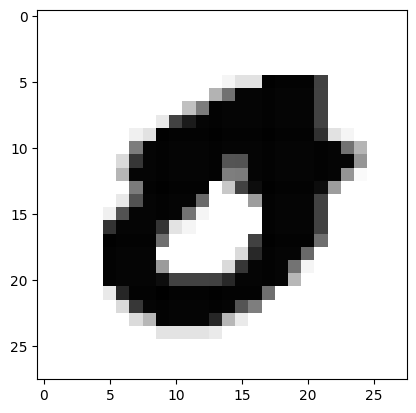

In [10]:
digit = 555
plt.imshow(train_ar[:,:,digit], cmap='Greys')

In [11]:
image = train_ar[:,:,digit].astype("uint8")
contours, hierarchy = cv2.findContours(image, cv2.RETR_LIST, cv2.CHAIN_APPROX_NONE)
contours = sorted(contours, key = cv2.contourArea, reverse = True)
largestContour = contours[0]
minAreaRect = cv2.minAreaRect(largestContour)
minAreaRect

((13.794116973876953, 14.323528289794922),
 (16.120866775512695, 21.951818466186523),
 59.036251068115234)

In [12]:
box = cv2.boxPoints(minAreaRect)
box = np.int0(box)

C:\Users\AbdElrahman Amer\AppData\Local\Temp\ipykernel_15952\797469291.py:2: DeprecationWarning: `np.int0` is a deprecated alias for `np.intp`.  (Deprecated NumPy 1.24)
  box = np.int0(box)


In [13]:
box

array([[ 0, 13],
       [19,  1],
       [27, 15],
       [ 8, 26]], dtype=int64)

correcting angle

In [14]:
if(np.linalg.norm(box[0]-box[1])>np.linalg.norm(box[0]-box[3]) and minAreaRect[-1]<=45):
       angle = minAreaRect[-1]
elif(np.linalg.norm(box[0]-box[1])<np.linalg.norm(box[0]-box[3]) and minAreaRect[-1]>=45):
       angle = minAreaRect[-1] - 90
if(np.linalg.norm(box[0]-box[1])<=np.linalg.norm(box[0]-box[3]) and minAreaRect[-1]<45):
       angle = minAreaRect[-1]
elif(np.linalg.norm(box[0]-box[1])>=np.linalg.norm(box[0]-box[3]) and minAreaRect[-1]>45):
       angle = minAreaRect[-1] - 90
if(np.linalg.norm(box[0]-box[1])==np.linalg.norm(box[0]-box[3]) and minAreaRect[-1]==45):
       angle = minAreaRect[-1]

In [15]:
newImage = image.copy()
(h, w) = newImage.shape[:2]
center = (w // 2, h // 2)
M = cv2.getRotationMatrix2D(center, angle, 1.0)
newImage = cv2.warpAffine(newImage, M, (w, h), flags=cv2.INTER_CUBIC, borderMode=cv2.BORDER_REPLICATE)

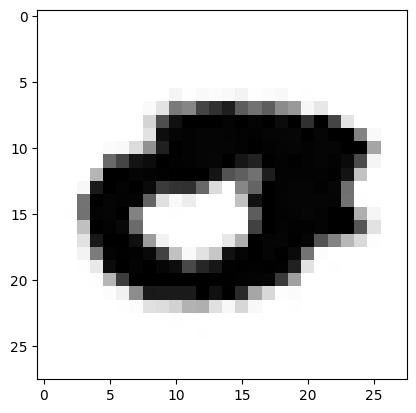

In [16]:
plt.imshow(newImage, cmap='Greys')

In [17]:
def deskewing(image):
    image = image.astype("uint8")
    contours, hierarchy = cv2.findContours(image, cv2.RETR_LIST, cv2.CHAIN_APPROX_NONE)
    contours = sorted(contours, key = cv2.contourArea, reverse = True)

    largestContour = contours[0]
    minAreaRect = cv2.minAreaRect(largestContour)
    box = cv2.boxPoints(minAreaRect)
    box = np.int0(box)

    if(np.linalg.norm(box[0]-box[1])>np.linalg.norm(box[0]-box[3]) and minAreaRect[-1]<=45):
           angle = minAreaRect[-1]
    elif(np.linalg.norm(box[0]-box[1])<np.linalg.norm(box[0]-box[3]) and minAreaRect[-1]>=45):
           angle = minAreaRect[-1] - 90
    if(np.linalg.norm(box[0]-box[1])<=np.linalg.norm(box[0]-box[3]) and minAreaRect[-1]<45):
           angle = minAreaRect[-1]
    elif(np.linalg.norm(box[0]-box[1])>=np.linalg.norm(box[0]-box[3]) and minAreaRect[-1]>45):
           angle = minAreaRect[-1] - 90
    if(np.linalg.norm(box[0]-box[1])==np.linalg.norm(box[0]-box[3]) and minAreaRect[-1]==45):
           angle = minAreaRect[-1]
    (h, w) = image.shape[:2]
    center = (w // 2, h // 2)
    try: 
        M = cv2.getRotationMatrix2D(center, angle, 1.0)
    except:
        print('nope', minAreaRect[-1],np.linalg.norm(box[0]-box[1]),np.linalg.norm(box[0]-box[3]))
    newImage = cv2.warpAffine(image, M, (w, h), flags=cv2.INTER_CUBIC, borderMode=cv2.BORDER_REPLICATE)
    newImage = newImage.flatten()

    return newImage

In [18]:
train_rows_list = []
for i in range(train_df.shape[0]):
    flat_train = train_df.loc[:, train_df.columns != 'label'].iloc[i].values
    train_ = np.empty((28,28))
    for i in range(28):#rows
        for j in range(28):#columns
            train_[i][j] = flat_train[i*28+j]
            
    train_rows_list.append(deskewing(train_))


C:\Users\AbdElrahman Amer\AppData\Local\Temp\ipykernel_15952\3842663991.py:9: DeprecationWarning: `np.int0` is a deprecated alias for `np.intp`.  (Deprecated NumPy 1.24)
  box = np.int0(box)


In [19]:
train_rows_df = pd.DataFrame(train_rows_list, columns = train_df.columns[train_df.columns!='label'])
train_rows_df

pixel0  pixel1  pixel2  pixel3  pixel4  pixel5  pixel6  pixel7  pixel8  \
0           0       0       0       0       0       0       0       0       0   
1           0       0       0       0       0       0       0       0       0   
2           0       0       0       0       0       0       0       0       0   
3           0       0       0       0       0       0       0       0       0   
4           0       0       0       0       0       0       0       0       0   
...       ...     ...     ...     ...     ...     ...     ...     ...     ...   
41995       0       0       0       0       0       0       0       0       0   
41996       0       0       0       0       0       0       0       0       0   
41997       0       0       0       0       0       0       0       0       0   
41998       0       0       0       0       0       0       0       0       0   
41999       0       0       0       0       0       0       0       0       0   

       pixel9  ...  pixel774  pixel775  pixel776  pixel777  pixel778  \
0           0  ...         0         0         0         0         0   
1           0  ...         0         0         0         0         0   
2           0  ...         0         0         0         0         0   
3           0  ...         0         0         0         0         0   
4           0  ...         0         0         0         0         0   
...       ...  ...       ...       ...       ...       ...       ...   
41995       0  ...         0         0         0         0         0   
41996       0  ...         0         0         0         0         0   
41997       0  ...         0         0         0         0         0   
41998       0  ...         0         0         0         0         0   
41999       0  ...         0         0         0         0         0   

       pixel779  pixel780  pixel781  pixel782  pixel783  
0             0         0         0         0         0  
1             0         0         0         0         0  
2             0         0         0         0         0  
3             0         0         0         0         0  
4             0         0         0         0         0  
...         ...       ...       ...       ...       ...  
41995         0         0         0         0         0  
41996         0         0         0         0         0  
41997         0         0         0         0         0  
41998         0         0         0         0         0  
41999         0         0         0         0         0  

[42000 rows x 784 columns]

In [20]:
test_row_list = []
for i in range(test_df.shape[0]):
    flat_test = test_df.iloc[i].values
    test_ = np.empty((28,28))
    for i in range(28):#rows
        for j in range(28):#columns
            test_[i][j] = flat_test[i*28+j]
            
    test_row_list.append(deskewing(test_))

C:\Users\AbdElrahman Amer\AppData\Local\Temp\ipykernel_15952\3842663991.py:9: DeprecationWarning: `np.int0` is a deprecated alias for `np.intp`.  (Deprecated NumPy 1.24)
  box = np.int0(box)


In [21]:
test_rows_df = pd.DataFrame(test_row_list, columns = test_df.columns)
test_rows_df

pixel0  pixel1  pixel2  pixel3  pixel4  pixel5  pixel6  pixel7  pixel8  \
0           0       0       0       0       0       0       0       0       0   
1           0       0       0       0       0       0       0       0       0   
2           0       0       0       0       0       0       0       0       0   
3           0       0       0       0       0       0       0       0       0   
4           0       0       0       0       0       0       0       0       0   
...       ...     ...     ...     ...     ...     ...     ...     ...     ...   
27995       0       0       0       0       0       0       0       0       0   
27996       0       0       0       0       0       0       0       0       0   
27997       0       0       0       0       0       0       0       0       0   
27998       0       0       0       0       0       0       0       0       0   
27999       0       0       0       0       0       0       0       0       0   

       pixel9  ...  pixel774  pixel775  pixel776  pixel777  pixel778  \
0           0  ...         0         0         0         0         0   
1           0  ...         0         0         0         0         0   
2           0  ...         0         0         0         0         0   
3           0  ...         0         0         0         0         0   
4           0  ...         0         0         0         0         0   
...       ...  ...       ...       ...       ...       ...       ...   
27995       0  ...         0         0         0         0         0   
27996       0  ...         0         0         0         0         0   
27997       0  ...         0         0         0         0         0   
27998       0  ...         0         0         0         0         0   
27999       0  ...         0         0         0         0         0   

       pixel779  pixel780  pixel781  pixel782  pixel783  
0             0         0         0         0         0  
1             0         0         0         0         0  
2             0         0         0         0         0  
3             0         0         0         0         0  
4             0         0         0         0         0  
...         ...       ...       ...       ...       ...  
27995         0         0         0         0         0  
27996         0         0         0         0         0  
27997         0         0         0         0         0  
27998         0         0         0         0         0  
27999         0         0         0         0         0  

[28000 rows x 784 columns]

In [22]:
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')
X_train = train_df.loc[:, train_df.columns != 'label'].values
y_train = train_df['label'].values
X_test = test_df.values

In [23]:
X_train = train_rows_df.values[:35000]
y_train = train_df['label'].values[:35000]

In [24]:
X_test = train_rows_df.values[35000:]
y_test = train_df['label'].values[35000:]

In [25]:
X_train.shape

(35000, 784)

In [26]:
clf = OneVsOneClassifier(
    Perceptron()).fit(X_train, y_train)#Perceptron(tol=1e-3, random_state=0)

In [27]:
clf.score(X_test,y_test)

0.9012857142857142

without preprocessing

In [28]:
X_train = train_df.loc[:, train_df.columns != 'label'].values[:35000]
y_train = train_df['label'].values[:35000]
X_test = train_df.loc[:, train_df.columns != 'label'].values[35000:]
y_test = train_df['label'].values[35000:]

In [29]:
clf = OneVsOneClassifier(
    Perceptron()).fit(X_train, y_train)

In [30]:
clf.score(X_test,y_test)

0.9165714285714286

In [31]:
X_train = train_df.loc[:, train_df.columns != 'label'].values
all_ar = np.empty((42000,28,28,1))

for m in range(42000):#digit
    for i in range(28):#rows
        for j in range(28):#columns
            all_ar[m][i][j][0] = X_train[m,i*28+j]

In [32]:
x_train = all_ar[:30000,:,:,:]
y_train = train_df['label'].values[:30000]

x_val = all_ar[30000:35000,:,:,:]
y_val = train_df['label'].values[30000:35000]

x_test = all_ar[35000:42000,:,:,:]
y_test = train_df['label'].values[35000:42000]

In [33]:
def preprocess(x, y):
    x = tf.cast(x, tf.float32) / 255.0
    y = tf.cast(y, tf.int64)
    return x, y

def create_dataset(xs, ys, n_classes=10):
    
    ys = tf.one_hot(ys, depth=n_classes)
    return tf.data.Dataset.from_tensor_slices((xs, ys)) \
        .map(preprocess) \
        .shuffle(len(ys)) \
        .batch(200)

In [34]:
train_dataset = create_dataset(x_train, y_train)
val_dataset = create_dataset(x_val, y_val)
test_dataset = create_dataset(x_test, y_test)

In [35]:
model1 = keras.Sequential([
    keras.layers.Conv2D(100, (3, 3), activation='relu', kernel_initializer='he_uniform', input_shape=(28,28,1)),#input_shape is  (batch, rows, cols, channels) if data_format is "channels_last".
    
    keras.layers.MaxPooling2D((2, 2)),
    
    keras.layers.Conv2D(100, (3, 3), activation='relu', kernel_initializer='he_uniform'),#input_shape is  (batch, rows, cols, channels) if data_format is "channels_last".
    
    keras.layers.MaxPooling2D((2, 2)),
    
    keras.layers.Conv2D(100, (3, 3), activation='relu', kernel_initializer='he_uniform'),#input_shape is  (batch, rows, cols, channels) if data_format is "channels_last".
    
    keras.layers.Flatten(),
    
    keras.layers.Dense(
      units=100, activation='relu',  kernel_initializer='he_uniform'
    ),
    
    keras.layers.Dense(
      units=10, activation = 'softmax'
    )
])

model1.compile(
  optimizer=tf.keras.optimizers.SGD(learning_rate=0.005),
  loss=tf.losses.CategoricalCrossentropy(from_logits=True),
  metrics=['accuracy']
)

history = model1.fit(
    train_dataset.repeat(),
    epochs=50,
    steps_per_epoch=150,
    validation_data = val_dataset.repeat(),
    validation_steps=25
)

f:\APP\Programming tools\Python\lib\site-packages\keras\src\layers\convolutional\base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


Epoch 1/50


f:\APP\Programming tools\Python\lib\site-packages\keras\src\backend\tensorflow\nn.py:559: UserWarning: "`categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


150/150 ━━━━━━━━━━━━━━━━━━━━ 22s 116ms/step - accuracy: 0.5763 - loss: 1.4550 - val_accuracy: 0.8880 - val_loss: 0.3989
Epoch 2/50
150/150 ━━━━━━━━━━━━━━━━━━━━ 18s 122ms/step - accuracy: 0.8919 - loss: 0.3748 - val_accuracy: 0.9206 - val_loss: 0.2708
Epoch 3/50
150/150 ━━━━━━━━━━━━━━━━━━━━ 18s 118ms/step - accuracy: 0.9223 - loss: 0.2668 - val_accuracy: 0.9298 - val_loss: 0.2320
Epoch 4/50
150/150 ━━━━━━━━━━━━━━━━━━━━ 18s 117ms/step - accuracy: 0.9351 - loss: 0.2136 - val_accuracy: 0.9486 - val_loss: 0.1785
Epoch 5/50
150/150 ━━━━━━━━━━━━━━━━━━━━ 18s 117ms/step - accuracy: 0.9464 - loss: 0.1835 - val_accuracy: 0.9518 - val_loss: 0.1652
Epoch 6/50
150/150 ━━━━━━━━━━━━━━━━━━━━ 17s 116ms/step - accuracy: 0.9479 - loss: 0.1754 - val_accuracy: 0.9588 - val_loss: 0.1485
Epoch 7/50
150/150 ━━━━━━━━━━━━━━━━━━━━ 18s 118ms/step - accuracy: 0.9579 - loss: 0.1417 - val_accuracy: 0.9644 - val_loss: 0.1262
Epoch 8/50
150/150 ━━━━━━━━━━━━━━━━━━━━ 18s 117ms/step - accuracy: 0.9617 - loss: 0.1329 - val

In [36]:
def plot_metrics(metric1, metric2):
    fig = go.Figure()
    x = np.arange(0,len(history.history[metric1]),1)
    y1 = history.history[metric1]
    y2 = history.history[metric2]
    fig.add_trace(go.Scatter(x=x, y=y1,
                        mode='lines', marker = dict(size=6, color = '#D100FF'),
                        name=metric1))
    fig.add_trace(go.Scatter(x=x, y=y2,
                        mode='lines', marker = dict(size=6, color = '#1BFF00'),
                        name=metric2))
    fig.update_layout(title=metric1+' and '+metric2, width=800, height=400,
                      xaxis = dict(title = 'Epoch'))


    return fig

In [37]:
plot_metrics('accuracy','val_accuracy')

In [38]:
test_loss, test_acc = model1.evaluate(test_dataset, verbose=2)

35/35 - 1s - 39ms/step - accuracy: 0.9830 - loss: 0.0555


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Calculate the confusion matrix
cm = confusion_matrix(test_labels, prediction_labels)

# Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

In [39]:
X_test = test_df.loc[:, test_df.columns].values
test_ar = np.empty((test_df.shape[0],28,28,1))

for m in range(test_df.shape[0]):#digits
    for i in range(28):#rows
        for j in range(28):#columns
            test_ar[m][i][j][0] = X_test[m,i*28+j]

In [40]:
test_ar.shape

(28000, 28, 28, 1)

Real Number


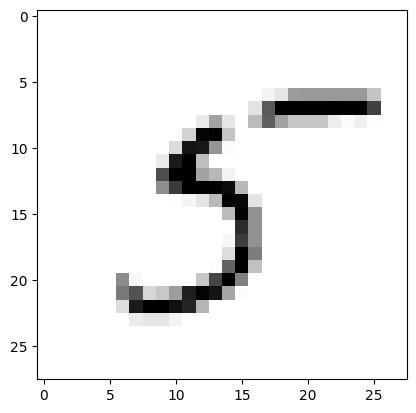

Prediction: 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 305ms/step
5
Real Number


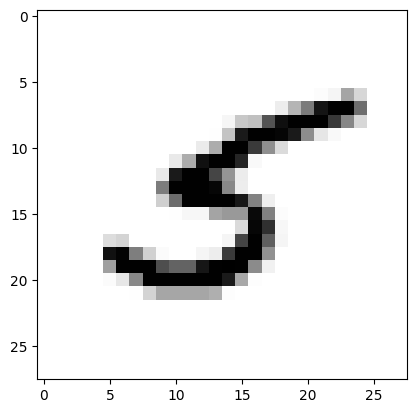

Prediction: 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
5
Real Number


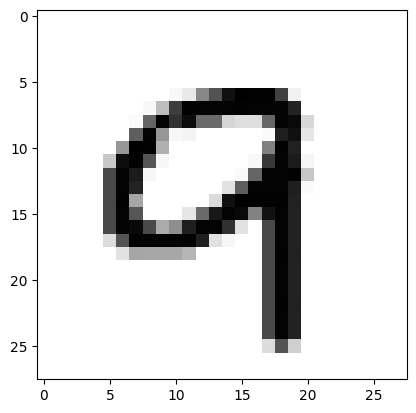

Prediction: 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
9
Real Number


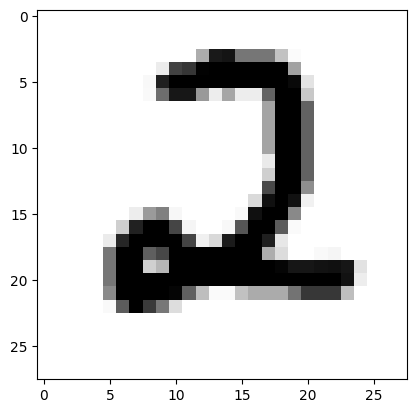

Prediction: 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
2
Real Number


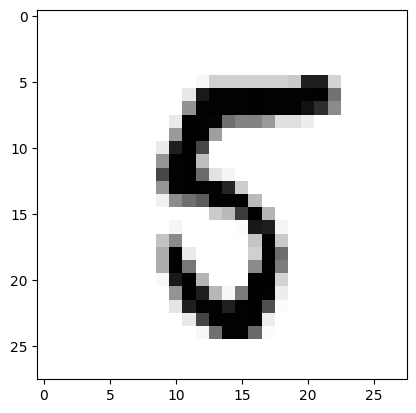

Prediction: 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
5
Real Number


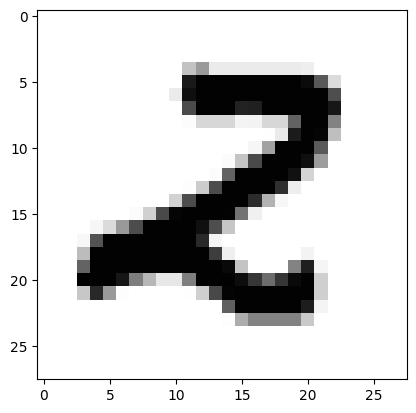

Prediction: 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
2
Real Number


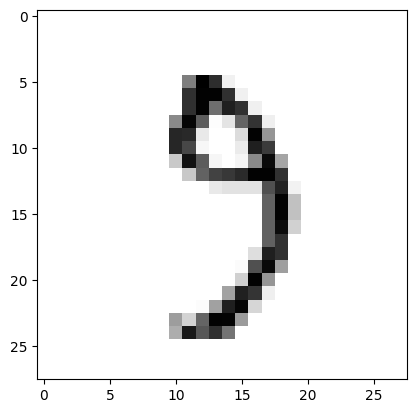

Prediction: 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
9
Real Number


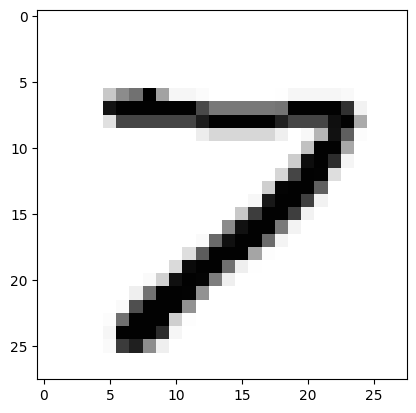

Prediction: 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
7
Real Number


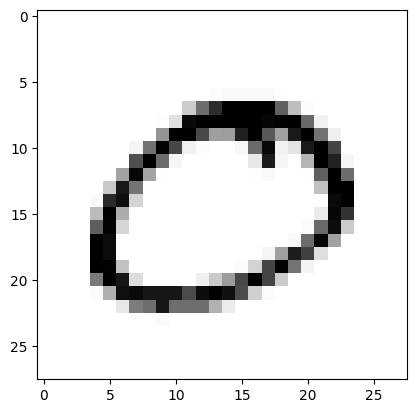

Prediction: 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
0
Real Number


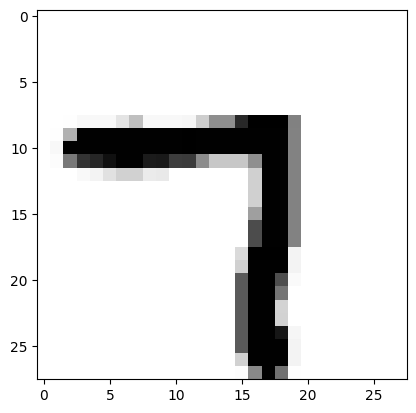

Prediction: 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
7


In [41]:
for i in range(10):
    print('Real Number')
    digit = np.random.randint(0,X_test.shape[0]-1)
    plt.imshow(test_ar[digit,:,:,:], cmap='Greys')   
    plt.show()
    x_test = np.empty((1,28,28,1))
    for m in range(28):#rows
        for n in range(28):#columns
            x_test[0][m][n][0] = X_test[digit,m*28+n]
    x_test = tf.cast(x_test, tf.float32)/255
    print('Prediction: ')
    print(model1.predict(x_test).argmax())
    

In [42]:

result = model1.predict(test_ar)

875/875 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step


In [43]:
Label = []
for i in result:
    Label.append(np.argmax(i))

In [44]:
results_df = pd.DataFrame({'ImageId':[i for i in range(1,28001)],'Label':Label})
results_df.to_csv('results.csv', index=False)

In [45]:
l = [i for i in range(25,35)]
l

[25, 26, 27, 28, 29, 30, 31, 32, 33, 34]

In [46]:
[i for i in range(1,28001)][-1]

28000

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Calculate the confusion matrix
cm = confusion_matrix(X_test, result)

# Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()